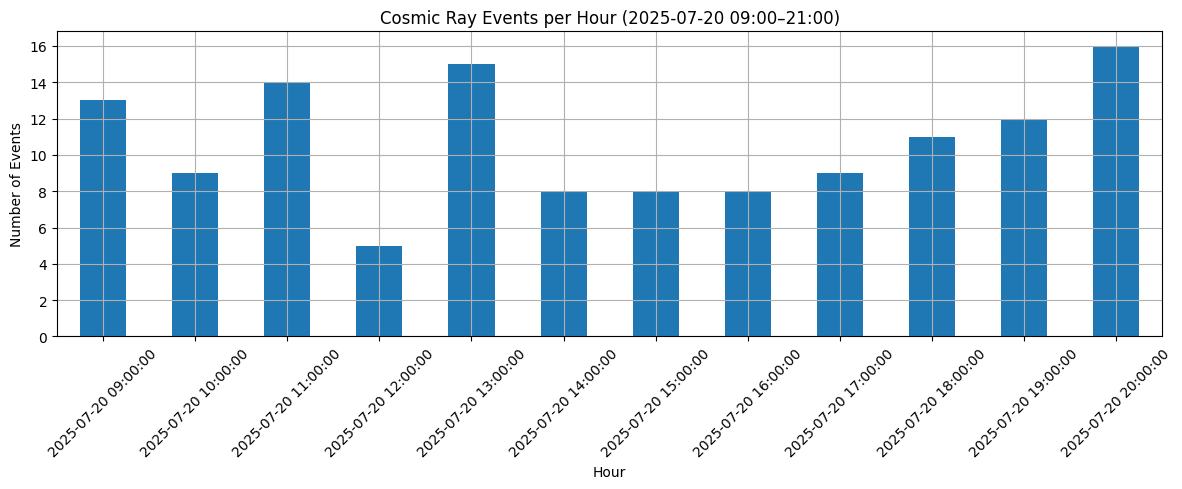

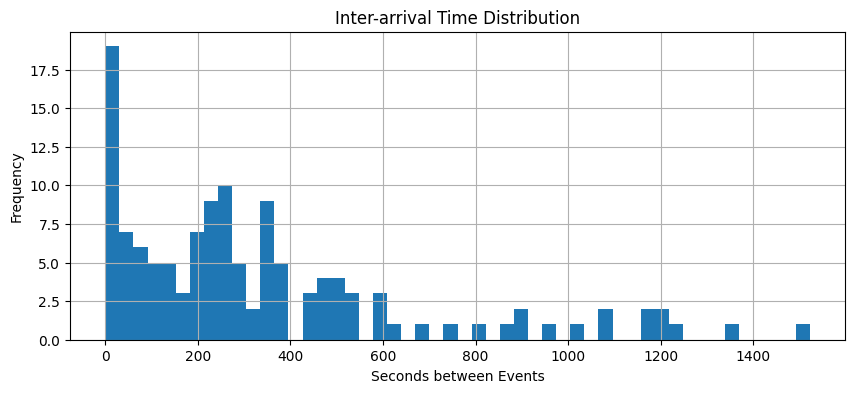

Total events: 128
Duration: 42847.6 seconds
Estimated flux: 1.4587e-02 events/cm²/s
Flux: 0.8752 events/cm²/min


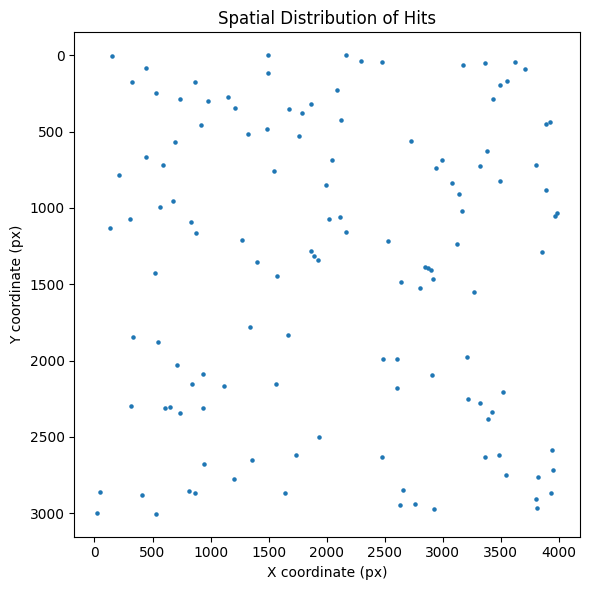

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

file_path = "soramame_Raspi Soramame Sora06-A_20250720_0900_20250720_2100.csv"
base_dir = os.path.dirname(file_path)
figures_dir = os.path.join(base_dir, "figures")
os.makedirs(figures_dir, exist_ok=True)

df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('datetime')
df.set_index('datetime', inplace=True)

hourly_counts = df.resample('h').size()


plt.figure(figsize=(12, 5))
hourly_counts.plot(kind='bar')
plt.title("Cosmic Ray Events per Hour (2025-07-20 09:00–21:00)")
plt.xlabel("Hour")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(figures_dir, "events_per_hour.png"))
plt.show()

df_reset = df.reset_index()
df_reset['time_diff_sec'] = df_reset['datetime'].diff().dt.total_seconds()
time_diffs = df_reset['time_diff_sec'].dropna()

plt.figure(figsize=(10, 4))
plt.hist(time_diffs, bins=50)
plt.title("Inter-arrival Time Distribution")
plt.xlabel("Seconds between Events")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(os.path.join(figures_dir, "interarrival_histogram.png"))
plt.show()

total_events = len(df_reset)
total_time_s = (df_reset['datetime'].iloc[-1] - df_reset['datetime'].iloc[0]).total_seconds()
sensor_area_cm2 = 0.2048  # assumed CMOS area
flux = total_events / (sensor_area_cm2 * total_time_s)
flux_per_min = flux * 60

print(f"Total events: {total_events}")
print(f"Duration: {total_time_s:.1f} seconds")
print(f"Estimated flux: {flux:.4e} events/cm²/s")
print(f"Flux: {flux_per_min:.4f} events/cm²/min")

plt.figure(figsize=(6, 6))
plt.scatter(df['coordinate_x'], df['coordinate_y'], s=5)
plt.title("Spatial Distribution of Hits")
plt.xlabel("X coordinate (px)")
plt.ylabel("Y coordinate (px)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "spatial_distribution.png"))
plt.show()


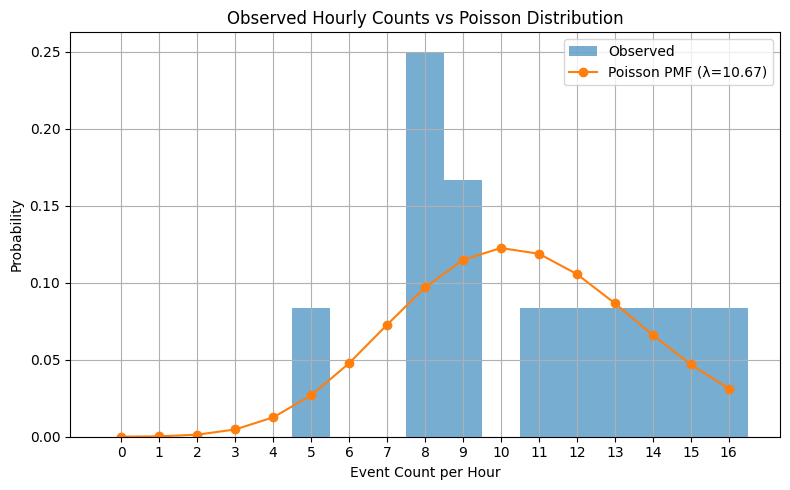

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

file_path = "soramame_Raspi Soramame Sora06-A_20250720_0900_20250720_2100.csv"
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['timestamp'])

df.set_index('datetime', inplace=True)
hourly_counts = df.resample('h').size()


lambda_est = hourly_counts.mean()


k_values = np.arange(0, hourly_counts.max() + 1)
pmf_values = poisson.pmf(k_values, mu=lambda_est)

plt.figure(figsize=(8, 5))
counts, bins, _ = plt.hist(hourly_counts, bins=range(int(hourly_counts.max())+2), 
                           density=True, alpha=0.6, align='left', label='Observed')
plt.plot(k_values, pmf_values, 'o-', label=f'Poisson PMF (λ={lambda_est:.2f})')
plt.title("Observed Hourly Counts vs Poisson Distribution")
plt.xlabel("Event Count per Hour")
plt.ylabel("Probability")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/poisson_fit_hourly_counts.png")
plt.show()


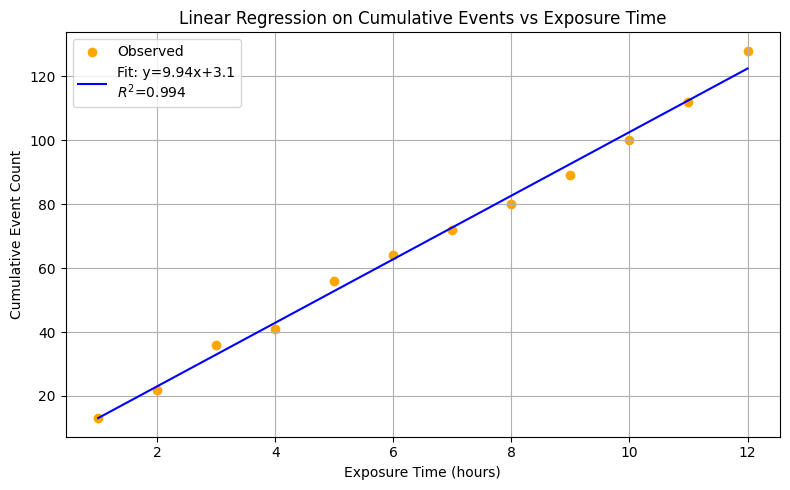

Slope (events/hour): 9.94
R-squared: 0.994


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "soramame_Raspi Soramame Sora06-A_20250720_0900_20250720_2100.csv"
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['timestamp'])
df = df.set_index('datetime').sort_index()

hourly_counts = df.resample('h').size()
exposure_hours = np.arange(1, len(hourly_counts) + 1)
cumulative_events = np.cumsum(hourly_counts)

coeffs = np.polyfit(exposure_hours, cumulative_events, 1)
slope, intercept = coeffs
predicted = slope * exposure_hours + intercept

ss_res = np.sum((cumulative_events - predicted) ** 2)
ss_tot = np.sum((cumulative_events - np.mean(cumulative_events)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.figure(figsize=(8, 5))
plt.scatter(exposure_hours, cumulative_events, label="Observed", color="orange")
plt.plot(exposure_hours, predicted, label=f"Fit: y={slope:.2f}x+{intercept:.1f}\n$R^2$={r_squared:.3f}", color="blue")
plt.xlabel("Exposure Time (hours)")
plt.ylabel("Cumulative Event Count")
plt.title("Linear Regression on Cumulative Events vs Exposure Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/linear regression Cum-events vs Exp time.png")
plt.show()

print(f"Slope (events/hour): {slope:.2f}")
print(f"R-squared: {r_squared:.3f}")
